# Hands on tutorial of Graph Representation Learning

In this lecture, we will go through the following topics
1. Graph structued data in Python
2. GNN package - Pytorch-Geometric introduction
3. Representation in Graphs - node2vec, GCN
4. GNN with downstrean tasks
5. GNN for text classification


In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html

import torch_cluster
import os.path as osp
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

2.2.1


## Obtaining node embedding with Graph Neural Network
For a GNN layer, Message Passing is defined as the process of taking node features of the neighbours, transforming them, and "passing" them to the source node. This process is repeated, in parallel, for all nodes in the graph. In that way, all neighbourhoods are examined by the end of this step.

### Node2vec v.s. GNN
Previously, we learned how to obtain node embedding with Node2vec. However, Node2vec uses the embedding layer as the node feature **without considering the node feature**. GNN, on the contrary, adopts a different way to learn node embedding via the so-called **Message Passing** function or **Neighbor Aggregation** operation which obtains embedding by aggregating information from neighboring nodes.

### A simple GNN
Let first build a bisic GNN to demonstrate the message passing of GNN.
The node embedding of each node is defined as follows:

\begin{equation}
z^k_i = \sum_{j\in N(i)} z^{k-1}_j
\end{equation}

![](https://i.imgur.com/77VBsTd.png)

In [2]:
from torch_geometric.nn import MessagePassing

In [3]:
class SimpleGNN(MessagePassing):
    def __init__(self,aggr="sum"):
        super().__init__(aggr=aggr)

    def forward(self, x, edge_index):
        return self.propagate(edge_index,x=x)

In [4]:
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]]
edge_index = torch.tensor(edge_index).T
print(x)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])


In [6]:
model = SimpleGNN()
model
model(x,edge_index)

tensor([[ 0.,  0.,  0.],
        [ 6.,  8., 10.],
        [ 0.,  0.,  0.]])

### Bidrectional edges

In [7]:
from torch_geometric.utils import to_undirected
edge_index = to_undirected(edge_index)
print(edge_index)

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


In [8]:
model = SimpleGNN()
model
model(x,edge_index)

tensor([[ 3.,  4.,  5.],
        [ 6.,  8., 10.],
        [ 3.,  4.,  5.]])

### Adding self-connection
![](https://i.imgur.com/h2x1Qq5.png)

In [9]:
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]] + [[0,0],[1,1],[2,2]]
edge_index = torch.tensor(edge_index).T
print(x)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])


In [10]:
model = SimpleGNN()
model(x,edge_index)

tensor([[ 0.,  1.,  2.],
        [ 9., 12., 15.],
        [ 6.,  7.,  8.]])

### Advance implementation of self-connection

In [11]:
# another way to implement self-connection
class SimpleGNN(MessagePassing):
    def __init__(self,aggr="sum"):
        super().__init__(aggr=aggr)

    def forward(self, x, edge_index):
        print(x)
        return self.propagate(edge_index,x=x) + x

In [13]:
x = torch.arange(9).reshape(3,3)
edge_index = [[0,1],[2,1]]
edge_index = torch.tensor(edge_index).T
print(x)

model = SimpleGNN()
model(x,edge_index)

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])
tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])


tensor([[ 0,  1,  2],
        [ 9, 12, 15],
        [ 6,  7,  8]])

###  More common usage: bidirectional edges with self-connection

In [15]:
# bidirectional edges with self-connection
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]]
edge_index = torch.tensor(edge_index).T
edge_index = to_undirected(edge_index)
print(edge_index)
print(x)

model = SimpleGNN()
model(x,edge_index)

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])


tensor([[ 3.,  5.,  7.],
        [ 9., 12., 15.],
        [ 9., 11., 13.]])

### Differnt pooling function
There are various pooling function you can choose during the message passing stage to control how those information was aggregated. <br>
**Sum, Mean and Max Pooling** are the most common and widely used operation.

In [16]:
# another way to implement self-connection
class SimpleGNN(MessagePassing):
    def __init__(self,**kwagrs):
        super().__init__(**kwagrs)

    def forward(self, x, edge_index):
        return self.propagate(edge_index,x=x)

In [17]:
# bidirectional edges with self-connection
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]] + [[0,0],[1,1],[2,2]]
edge_index = torch.tensor(edge_index).T
edge_index = to_undirected(edge_index)
print(x)

# sum pooling
model = SimpleGNN(aggr="sum")
print("Results of sum pooling...")
print(model(x,edge_index))
print("-"*30)

# mean pooling
model = SimpleGNN(aggr="mean")
print("Results of mean pooling...")
print(model(x,edge_index))
print("-"*30)

# sum pooling
model = SimpleGNN(aggr="max")
print("Results of max pooling...")
print(model(x,edge_index))
print("-"*30)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
Results of sum pooling...
tensor([[ 3.,  5.,  7.],
        [ 9., 12., 15.],
        [ 9., 11., 13.]])
------------------------------
Results of mean pooling...
tensor([[1.5000, 2.5000, 3.5000],
        [3.0000, 4.0000, 5.0000],
        [4.5000, 5.5000, 6.5000]])
------------------------------
Results of max pooling...
tensor([[3., 4., 5.],
        [6., 7., 8.],
        [6., 7., 8.]])
------------------------------


### The most powerful techniques of GNN: Exploring multi-hop neighbor by stacking GNN layers

In [20]:
# bidirectional edges 
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]]
edge_index = torch.tensor(edge_index).T
edge_index = to_undirected(edge_index)
model = SimpleGNN(aggr="sum")
print(x)
# first-hop neighbor
print("Embedding after first message passing...")
first_embedding = model(x,edge_index)
print(first_embedding)

# second-hop neighbor
print("Embedding after second message passing...")
second_embedding = model(first_embedding,edge_index)
print(second_embedding)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
Embedding after first message passing...
tensor([[ 3.,  4.,  5.],
        [ 6.,  8., 10.],
        [ 3.,  4.,  5.]])
Embedding after second message passing...
tensor([[ 6.,  8., 10.],
        [ 6.,  8., 10.],
        [ 6.,  8., 10.]])


In [22]:
# bidirectional edges with self-connection
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]] + [[0,0],[1,1],[2,2]]
edge_index = torch.tensor(edge_index).T
edge_index = to_undirected(edge_index)
model = SimpleGNN(aggr="sum")
print(x)
# first-hop neighbor
print("Embedding after first message passing...")
first_embedding = model(x,edge_index)
print(first_embedding)

# second-hop neighbor
print("Embedding after second message passing...")
second_embedding = model(first_embedding,edge_index)
print(second_embedding)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
Embedding after first message passing...
tensor([[ 3.,  5.,  7.],
        [ 9., 12., 15.],
        [ 9., 11., 13.]])
Embedding after second message passing...
tensor([[12., 17., 22.],
        [21., 28., 35.],
        [18., 23., 28.]])


In [23]:
# another way to implement multi-hop message passing
class SimpleGNN(MessagePassing):
    def __init__(self,n_layers=1,**kwagrs):
        super().__init__(**kwagrs)
        self.n_layers = n_layers

    def forward(self, x, edge_index):
        for _ in range(self.n_layers):
            x = self.propagate(edge_index,x=x)
        return x

In [24]:
# bidirectional edges with self-connection
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]] + [[0,0],[1,1],[2,2]]
edge_index = torch.tensor(edge_index).T
edge_index = to_undirected(edge_index)

# first-hop neighbor
print("Embedding after first message passing...")
model = SimpleGNN(n_layers=1,aggr="sum")
first_embedding = model(x,edge_index)
print(first_embedding)

# second-hop neighbor
print("Embedding after second message passing...")
model = SimpleGNN(n_layers=2,aggr="sum")
second_embedding = model(x,edge_index)
print(second_embedding)

Embedding after first message passing...
tensor([[ 3.,  5.,  7.],
        [ 9., 12., 15.],
        [ 9., 11., 13.]])
Embedding after second message passing...
tensor([[12., 17., 22.],
        [21., 28., 35.],
        [18., 23., 28.]])


In [25]:
# multi-hop neighbor
print("Embedding after second message passing...")
model = SimpleGNN(n_layers=10,aggr="sum")
second_embedding = model(x,edge_index)
print(second_embedding)

Embedding after second message passing...
tensor([[17220., 22961., 28702.],
        [24357., 32476., 40595.],
        [17226., 22967., 28708.]])


### Nueral Networks in GNN

In [26]:
# another way to implement multi-hop message passing
class CoolGNN(MessagePassing):
    def __init__(self,n_layers=1,**kwagrs):
        super().__init__(**kwagrs)
        self.n_layers = n_layers
        self.nn_layers = nn.ModuleList([nn.Linear(3,3) for _ in range(self.n_layers)])

    def forward(self, x, edge_index):
        for i in range(self.n_layers):
            x = self.nn_layers[i](self.propagate(edge_index,x=x))
            x = torch.relu(x)
        return x

In [27]:
# bidirectional edges with self-connection
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]] + [[0,0],[1,1],[2,2]]
edge_index = torch.tensor(edge_index).T
edge_index = to_undirected(edge_index)

# first-hop neighbor
print("Embedding after first message passing...")
model = CoolGNN(n_layers=1,aggr="sum")
first_embedding = model(x,edge_index)
print(first_embedding)

# second-hop neighbor
print("Embedding after second message passing...")
model = CoolGNN(n_layers=2,aggr="sum")
second_embedding = model(x,edge_index)
print(second_embedding)

Embedding after first message passing...
tensor([[0.0000, 0.0000, 2.8777],
        [0.0000, 0.0000, 5.1110],
        [0.0000, 0.0000, 4.2849]], grad_fn=<ReluBackward0>)
Embedding after second message passing...
tensor([[ 6.2564,  1.8328,  7.6890],
        [10.9392,  3.0531, 12.2015],
        [ 8.9492,  2.5327,  9.7289]], grad_fn=<ReluBackward0>)


In [28]:
# using off-the-shelf GNN models
from torch_geometric.nn import GCNConv, SAGEConv
print(x)
print(edge_index)
model = SAGEConv(in_channels=3,out_channels=16)
embedding = model(x,edge_index)
print(embedding)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
tensor([[0, 0, 1, 1, 1, 2, 2],
        [0, 1, 0, 1, 2, 1, 2]])
tensor([[ -0.5357,   3.8771,  -0.3024,  -1.1292,   0.1200,   1.1355,  -3.9670,
          -1.0765,  -0.6980,  -0.0885,  -2.4997,  -1.3338,  -0.1485,   1.2537,
          -0.1221,  -1.7636],
        [  0.0738,   5.4967,  -0.5369,  -1.0734,   1.3499,   0.8673,  -7.5815,
          -2.3885,  -2.5840,   1.0328,  -6.3315,  -1.1962,  -0.9050,   2.3035,
          -0.7748,  -4.7174],
        [  0.6833,   7.1163,  -0.7714,  -1.0176,   2.5799,   0.5992, -11.1961,
          -3.7006,  -4.4699,   2.1541, -10.1634,  -1.0586,  -1.6615,   3.3534,
          -1.4274,  -7.6711]], grad_fn=<AddBackward0>)


## Unsupervised GRL with GraphSAGE
Previously, we mentioned that Node2vec outperform MLP in semi-supervised node classification task.<br>
However, including both node feature and graph embedding did not boost the performance significantly. <br>
Here, we introduce the `GraphSAGE` that is a GNN based approach to model node feature and graph structure at the same time.

GraphSAGE stands for Graph **SA**mple and Aggre**G**at**E**. It's a model to generate node embeddings for large, very dense graphs (to be used at companies like Pinterest).

The work introduces learned aggregators on a node's neighbourhoods. Unlike traditional GATs or GCNs that consider all nodes in the neighbourhood, GraphSAGE uniformly samples the neighbours and uses the learned aggregators on them. 

Suppose we have $L$ layers in the network (depth), each layer $l \in \{1,\dots,L\}$ looks at a larger $l$-hop neighbourhood w.r.t. the source node (as one would expect). Each source node is then updated by concatenating the node embedding with the sampled messages before being passed through a MLP $F$ and non-linearity $\sigma$. 

For a certain layer $l$,

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

A simple mean aggregator could be:
\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

There are supervised and unsupervised learning framework for GraphSAGE. <br>
Here we present the unsupervised learning scheme which optimize the following objective:
\begin{equation}
\log \left ( \sigma (h_u^{\top} h_v)  \right) - \sum_{i=1}^k \log \left ( \sigma (h_u^{\top} h_{n_i})  \right), n_i \sim P_V
\end{equation}
![](https://snap.stanford.edu/graphsage/sample_and_agg.png)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(root=path, name='Cora', transform=NormalizeFeatures())
data = dataset[0]

Processing...
Done!


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from torch_cluster import random_walk

from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import SAGEConv

In [25]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        self.num_layers = num_layers
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, edge_index):
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

In [29]:
# define neighbor sampler
train_loader = LinkNeighborLoader(
    data,
    batch_size=256,
    shuffle=True,
    neg_sampling_ratio=1.0,
    num_neighbors=[10, 10],
)

In [30]:
data.edge_index.shape

torch.Size([2, 10556])

In [31]:
for batch in train_loader:
    print(batch)
    break

Data(x=[2417, 1433], edge_index=[2, 7785], y=[2417], train_mask=[2417], val_mask=[2417], test_mask=[2417], edge_label_index=[2, 512], edge_label=[512])


In [32]:
print("Edge label index: containing both positive and negative edges")
print(batch.edge_label_index)

print("Edge label: 1 stands for positive and 0 stands for negative node pair(edge)")
print(batch.edge_label)

Edge label index: containing both positive and negative edges
tensor([[137, 450, 570,  ..., 257,  82,  95],
        [210, 152, 502,  ..., 362, 341, 444]])
Edge label: 1 stands for positive and 0 stands for negative node pair(edge)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [33]:
# define training and testing functions
def train():
    model.train()

    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        embedding = model(batch.x, batch.edge_index)
        embedding_src = embedding[batch.edge_label_index[0]]
        embedding_dst = embedding[batch.edge_label_index[1]]
        pred = (embedding_src * embedding_dst).sum(dim=-1)
        loss = F.binary_cross_entropy_with_logits(pred, batch.edge_label)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * pred.size(0)

    return total_loss / data.num_nodes


@torch.no_grad()
def test():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

    clf = LogisticRegression()
    clf.fit(out[data.train_mask], data.y[data.train_mask])

    val_acc = clf.score(out[data.val_mask], data.y[data.val_mask])
    test_acc = clf.score(out[data.test_mask], data.y[data.test_mask])

    return val_acc, test_acc

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(data.num_node_features, hidden_channels=64, num_layers=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005,weight_decay=1e-4)
x, edge_index = data.x.to(device), data.edge_index.to(device)

In [35]:
for epoch in range(1, 101):
    loss = train()
    val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 5.1714, Val: 0.3620, Test: 0.3370
Epoch: 002, Loss: 4.6136, Val: 0.4200, Test: 0.3990
Epoch: 003, Loss: 4.4264, Val: 0.5080, Test: 0.4910
Epoch: 004, Loss: 4.1557, Val: 0.6180, Test: 0.6020
Epoch: 005, Loss: 4.0782, Val: 0.6320, Test: 0.6460
Epoch: 006, Loss: 4.0084, Val: 0.6640, Test: 0.6720
Epoch: 007, Loss: 4.0046, Val: 0.6940, Test: 0.7050
Epoch: 008, Loss: 3.9541, Val: 0.6880, Test: 0.7050
Epoch: 009, Loss: 3.9026, Val: 0.6860, Test: 0.7150
Epoch: 010, Loss: 3.8491, Val: 0.6980, Test: 0.7160
Epoch: 011, Loss: 3.8243, Val: 0.7180, Test: 0.7320
Epoch: 012, Loss: 3.8236, Val: 0.7360, Test: 0.7380
Epoch: 013, Loss: 3.8050, Val: 0.7220, Test: 0.7370
Epoch: 014, Loss: 3.7764, Val: 0.7080, Test: 0.7250
Epoch: 015, Loss: 3.7590, Val: 0.7180, Test: 0.7340
Epoch: 016, Loss: 3.7152, Val: 0.7200, Test: 0.7460
Epoch: 017, Loss: 3.7281, Val: 0.7020, Test: 0.7520
Epoch: 018, Loss: 3.6823, Val: 0.6960, Test: 0.7430
Epoch: 019, Loss: 3.6953, Val: 0.7100, Test: 0.7570
Epoch: 020, 

## Performance comparison
Recall that in the previous examples, we performed node classification in 3 different ways.
1. Bag of word + MLP with `Accuracy:0.6`
2. Node2vec + Logistic regression with `Accuracy:0.703`
3. Node2vec with Bag of word + Logistic regression with `Accuracy:0.707`
4. GraphSAGE: with Bag of word + Logistic regression with `Accuracy:0.791`

We noticed that node embedding + node feature cannot improve the performance significantly. <br>
However, we make use of node feature and graph structure at the same time and boost the accuracy up to **0.791** with a simple two-layer `GraphSAGE`.

## End-to-end semi-supervised learning with Graph Convolution Network(GCN)
Previously, we adopt a two stage classification pipeline where we first extract network feature via unsupervised learning then utilize a classifier to predict its label. <br>
The two-stage design could be suboptimal since the network features were not extracted for specific task. <br>
Hence, GCN is our best choice since GCN extract feature by aggregating information from neighboring nodes and making classification simultaneously.

In [37]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True,
                             normalize=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True,
                             normalize=True)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [38]:
dim = 64
model = GCN(dataset.num_features, dim, dataset.num_classes)
model, data = model.to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-4)
print(model)

GCN(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 7)
)


## Define training/testing fucntions

### Training stage
The GCN model takes two inputs: `x` and `edge_index` which represent the **node feature** and **edge index**, respectively. <br>
Note: The training procedure is slightly different than what we used to do. <br>
Since GNN takes the whole graph as input and output embeddings of individual nodes, the concept of "batch" does not apply here. 


In [39]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_weight)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_weight).argmax(dim=-1)
    mask = data.test_mask
    accs = (int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs

In [40]:
for epoch in range(400):
    loss = train()
    test_acc = test()
    print(f"Loss:{loss:.4f} Testing accuracy:{test_acc:.4f}")

Loss:1.9464 Testing accuracy:0.2600
Loss:1.9447 Testing accuracy:0.3180
Loss:1.9432 Testing accuracy:0.3820
Loss:1.9409 Testing accuracy:0.4560
Loss:1.9389 Testing accuracy:0.5250
Loss:1.9372 Testing accuracy:0.5910
Loss:1.9359 Testing accuracy:0.6260
Loss:1.9329 Testing accuracy:0.6580
Loss:1.9316 Testing accuracy:0.6840
Loss:1.9280 Testing accuracy:0.6960
Loss:1.9265 Testing accuracy:0.7150
Loss:1.9248 Testing accuracy:0.7230
Loss:1.9217 Testing accuracy:0.7250
Loss:1.9182 Testing accuracy:0.7310
Loss:1.9147 Testing accuracy:0.7290
Loss:1.9133 Testing accuracy:0.7340
Loss:1.9110 Testing accuracy:0.7390
Loss:1.9076 Testing accuracy:0.7400
Loss:1.9040 Testing accuracy:0.7420
Loss:1.9025 Testing accuracy:0.7490
Loss:1.8983 Testing accuracy:0.7520
Loss:1.8959 Testing accuracy:0.7560
Loss:1.8932 Testing accuracy:0.7600
Loss:1.8886 Testing accuracy:0.7590
Loss:1.8864 Testing accuracy:0.7630
Loss:1.8813 Testing accuracy:0.7640
Loss:1.8797 Testing accuracy:0.7650
Loss:1.8730 Testing accuracy

## Performance comparison
Recall that in the previous examples, we performed node classification in 3 different ways.
1. Bag of word + MLP with `Accuracy:0.6`
2. Node2vec + Logistic regression with `Accuracy:0.703`
3. Node2vec with Bag of word + Logistic regression with `Accuracy:0.707`
4. GraphSAGE: with Bag of word + Logistic regression with `Accuracy:0.791`
4. GCN: end-to-end learning with `Accuracy:0.812`

From this example, we clearly figure out that using GCN with end2end training leads to the best performance since the feature extracted could be learned to optimize the node classification task.

## Visualization

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


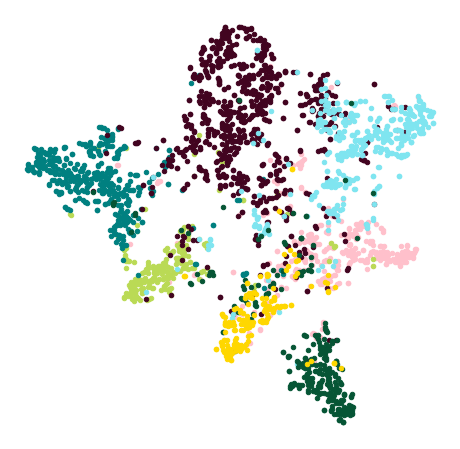

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(data.x, data.edge_index, data.edge_weight)
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)

### Compare GCN embedding with Node2vec embedding 
The following scatter plot is the node embedding we obtained from Node2vec in the previous example
![](https://i.imgur.com/7RG5zO6.png)

## Stacking multiple GCN layers to obtain higher order neighbor information



In [43]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True,
                             normalize=True)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, cached=True,
                             normalize=True)
        self.conv3 = GCNConv(hidden_channels, out_channels, cached=True,
                             normalize=True)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        return x

In [44]:
dim = 64
model = GCN(dataset.num_features, dim, dataset.num_classes)
model, data = model.to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-4)
print(model)

GCN(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 7)
)


In [45]:
for epoch in range(200):
    loss = train()
    test_acc = test()
    print(f"Loss:{loss:.4f} Testing accuracy:{test_acc:.4f}")

Loss:1.9457 Testing accuracy:0.2910
Loss:1.9452 Testing accuracy:0.3500
Loss:1.9438 Testing accuracy:0.3950
Loss:1.9430 Testing accuracy:0.4480
Loss:1.9418 Testing accuracy:0.4630
Loss:1.9411 Testing accuracy:0.4690
Loss:1.9399 Testing accuracy:0.4710
Loss:1.9384 Testing accuracy:0.4590
Loss:1.9361 Testing accuracy:0.4430
Loss:1.9350 Testing accuracy:0.4420
Loss:1.9332 Testing accuracy:0.4280
Loss:1.9331 Testing accuracy:0.4320
Loss:1.9307 Testing accuracy:0.4350
Loss:1.9279 Testing accuracy:0.4470
Loss:1.9266 Testing accuracy:0.4550
Loss:1.9243 Testing accuracy:0.4650
Loss:1.9206 Testing accuracy:0.4720
Loss:1.9208 Testing accuracy:0.4610
Loss:1.9167 Testing accuracy:0.4520
Loss:1.9137 Testing accuracy:0.4450
Loss:1.9105 Testing accuracy:0.4300
Loss:1.9067 Testing accuracy:0.4260
Loss:1.9055 Testing accuracy:0.4270
Loss:1.9027 Testing accuracy:0.4330
Loss:1.8984 Testing accuracy:0.4430
Loss:1.8956 Testing accuracy:0.4530
Loss:1.8924 Testing accuracy:0.4550
Loss:1.8842 Testing accuracy

## Applying different GNN backbone layer
The full list of implemented GNN could be found in [here.](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers)

In [46]:
from torch_geometric.nn import GCNConv,GATConv, GraphSAGE
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, gnn_type):
        super().__init__()
        if gnn_type == "GCN":
            self.GNN = GCNConv
        elif gnn_type == "SAGE":
            self.GNN = GraphSAGE
        elif gnn_type == "GAT":
            self.GNN = GATConv
        
        self.conv1 = self.GNN(in_channels, hidden_channels)
        self.conv2 = self.GNN(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [47]:
dim = 32
gnn_type = "GAT"
model = GNN(dataset.num_features, dim, dataset.num_classes,gnn_type=gnn_type)
model, data = model.to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters())
print(model)

GNN(
  (conv1): GATConv(1433, 32, heads=1)
  (conv2): GATConv(32, 7, heads=1)
)


# Practice: Link prediction with GNN
1. Try different GNN layer
2. Try to optimize the performance by stacking multiple layers
3. Report the best accuracy on testing set and the best model configuration(e.g., how many layers?)

In [48]:
# Let's practice how to use GNN for link prediction
# First we need to load the Cora dataset

import os.path as osp
import torch
from sklearn.metrics import roc_auc_score
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import negative_sampling


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=True),
])
dataset = Planetoid(path, name='Cora', transform=transform)
train_data, val_data, test_data = dataset[0]

In [49]:
print("--------Training data------")
print(train_data)
print("Training edges:")
print(train_data.edge_label_index)
print("Labels")
print(train_data.edge_label)

print()
print("--------Testing data------")
print(test_data)
print("Testing edges:")
print(test_data.edge_label_index)
print("Labels")
print(test_data.edge_label)

--------Training data------
Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[8976], edge_label_index=[2, 8976])
Training edges:
tensor([[1596,  484,  306,  ...,  669,  187,  532],
        [2476, 2046, 1640,  ..., 2617, 1372,  198]], device='cuda:0')
Labels
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')

--------Testing data------
Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])
Testing edges:
tensor([[ 310,  415, 1169,  ..., 2625,  345, 1044],
        [1331,  851, 1714,  ..., 1713, 1586, 1713]], device='cuda:0')
Labels
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')


In [50]:
class MyGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        ############################################################################
        # TODO: Your code here! 
        # create you GNN layer here. 
        # try to use different GNN backbone layer or stacking multiple layer to boost performance
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
        ############################################################################

    def forward(self, x, edge_index):
        ############################################################################
        # TODO: Your code here! 
        # Apply the forward pass acorrding to your GNN layers
        # you shoud return the embedding of each node (x has shape [num_nodes, dim])
        x = F.relu(self.conv1(x, edge_index))
        
        return self.conv2(x, edge_index)
        ############################################################################
    
    def get_prediction(self,node_embedding, edges):
        # In this function, we have the node embedding and edges as input
        # The output is to generate a scalar for each pair of edge
        # To generate such output, we use the inner product of embeddings of two nodes
        # Input shapes:
        #      node_embedding: (|V|, out_channels)
        #      edges: (2, number of edges)
        embedding_first_node = node_embedding[edges[0]]
        embedding_second_node = node_embedding[edges[1]]
        ############################################################################
        # TODO: Your code here! 
        # implement the element-wise product as edge feature for link prediction
        inner_product = torch.sum(embedding_first_node * embedding_second_node, dim=-1)
        
        ############################################################################
        return inner_product

In [51]:
############################################################################
# TODO: Your code here! 
# initiate your GNN model and select the criterion for link prediction

model = MyGNN(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
############################################################################

In [52]:
# Implement the train function
def train():
    model.train()
    optimizer.zero_grad()
    embedding = model(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    
    # Please assign the target for negative edges
    
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)
    
    # make prediction
    prediction = model.get_prediction(embedding, edge_label_index).view(-1)
    
    # optimization
    loss = criterion(prediction, edge_label)
    loss.backward()
    optimizer.step()
    return loss

In [53]:
# Implement the test function
@torch.no_grad()
def test(data):
    model.eval()
    embedding = model(data.x, data.edge_index)
    
    # use the sigmoid function to normalize our prediction into [0,1]
    out = model.get_prediction(embedding, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [54]:
best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')


Epoch: 001, Loss: 0.6932, Val: 0.6616, Test: 0.6858
Epoch: 002, Loss: 0.7005, Val: 0.7403, Test: 0.7538
Epoch: 003, Loss: 0.6937, Val: 0.6222, Test: 0.6598
Epoch: 004, Loss: 0.6935, Val: 0.5163, Test: 0.5471
Epoch: 005, Loss: 0.6940, Val: 0.5225, Test: 0.5192
Epoch: 006, Loss: 0.6944, Val: 0.5649, Test: 0.5557
Epoch: 007, Loss: 0.6943, Val: 0.6175, Test: 0.6413
Epoch: 008, Loss: 0.6939, Val: 0.6302, Test: 0.6136
Epoch: 009, Loss: 0.6936, Val: 0.6356, Test: 0.6328
Epoch: 010, Loss: 0.6934, Val: 0.6027, Test: 0.6005
Epoch: 011, Loss: 0.6933, Val: 0.5619, Test: 0.5481
Epoch: 012, Loss: 0.6934, Val: 0.4971, Test: 0.4798
Epoch: 013, Loss: 0.6934, Val: 0.4921, Test: 0.4760
Epoch: 014, Loss: 0.6935, Val: 0.5375, Test: 0.5343
Epoch: 015, Loss: 0.6934, Val: 0.6174, Test: 0.5976
Epoch: 016, Loss: 0.6933, Val: 0.7063, Test: 0.6495
Epoch: 017, Loss: 0.6932, Val: 0.7103, Test: 0.6547
Epoch: 018, Loss: 0.6931, Val: 0.7049, Test: 0.6613
Epoch: 019, Loss: 0.6929, Val: 0.7155, Test: 0.6676
Epoch: 020, 